# Exercise 11

Reweighting the 2d Ising model.

A c++ code to simulate this theory is available in the folder 'code', and the data from which these plots are made are in 'code/results'

A good and fairly short set of notes on reweighting is available here:
http://www.helsinki.fi/~rummukai/lectures/montecarlo_oulu/lectures/mc_notes4.pdf

In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (20,10)

In [2]:
def av(dat):
    return np.average(dat)

def err(dat):
    return np.sqrt(np.var(dat)/dat.size)

In [3]:
# Read raw data: array of [E/V, |M|/V] measurements for each L
# Simulations done at critical beta:
beta_0 = 0.5 * np.log(1.0 + np.sqrt(2.0))
Lvals = [8, 16, 32, 64]
dat = {}
for L in Lvals:
    dat[L] = L*L*np.loadtxt("code/results/L"+str(L)+".txt")

# return reweighting factor R_i for each value of E_i
# for reweighting from beta_0 to beta
def R_factor(beta, beta_0, E):
    E_shift = av(E)
    return np.exp(-(beta-beta_0)*(E-E_shift))

# return observable O reweighted with reweighting factor R
def O_rw(O, R):
    return av(O * R) / av(R)

# return jacknife error on reweighted (M, E, C)
def RW_err(dat, beta, beta_0):
    resampled_rwM = []
    resampled_rwE = []
    resampled_rwC = []
    for i_remove in range(dat[:,0].size):
        # make resampled set of data by removing i-th data point
        resampled_dat = np.delete(dat, i_remove, 0)
        resampled_E = resampled_dat[:,0]
        resampled_M = resampled_dat[:,1]
        resampled_EE = resampled_E*resampled_E
        resampled_R = R_factor(beta, beta_0, resampled_E)
        # Construct reweighted obs on this set of data
        rw_M = O_rw(resampled_M, resampled_R)
        rw_E = O_rw(resampled_E, resampled_R)
        rw_EE = O_rw(resampled_EE, resampled_R)
        # add to set of reweighted measurements
        resampled_rwM.append(rw_M)
        resampled_rwE.append(rw_E)
        resampled_rwC.append(np.power(beta,2)*(rw_EE - rw_E*rw_E))
    # return variance of the set of measurements
    errM = np.sqrt((dat.size-1.0)*np.var(resampled_rwM))
    errE = np.sqrt((dat.size-1.0)*np.var(resampled_rwE))
    errC = np.sqrt((dat.size-1.0)*np.var(resampled_rwC))
    return (errM, errE, errC)

# returns reweighted (M, E, C)
def RW_av(dat, beta, beta_0):
    # calculate reweighting factors
    E = dat[:,0]
    R = R_factor(beta, beta_0, E)
    # calculate reweighted observables
    M = dat[:,1]
    rw_M = O_rw(M, R)
    rw_E = O_rw(E, R)
    rw_EE = O_rw(E*E, R)
    return (rw_M, rw_E, np.power(beta,2)*(rw_EE - rw_E*rw_E))

reweighted_M = {}
reweighted_E = {}
reweighted_C = {}
for L in Lvals:
    V = L*L
    reweighted_M[L] = []
    reweighted_E[L] = []
    reweighted_C[L] = []
    for beta in np.arange(0.3, 0.6, 0.02):
        (avM, avE, avC) = RW_av(dat[L], beta, beta_0)
        (errM, errE, errC) = RW_err(dat[L], beta, beta_0)
        reweighted_M[L].append([beta, avM, errM])
        reweighted_E[L].append([beta, avE, errE])
        reweighted_C[L].append([beta, avC, errC])
    reweighted_M[L] = np.array(reweighted_M[L])
    reweighted_E[L] = np.array(reweighted_E[L])
    reweighted_C[L] = np.array(reweighted_C[L])

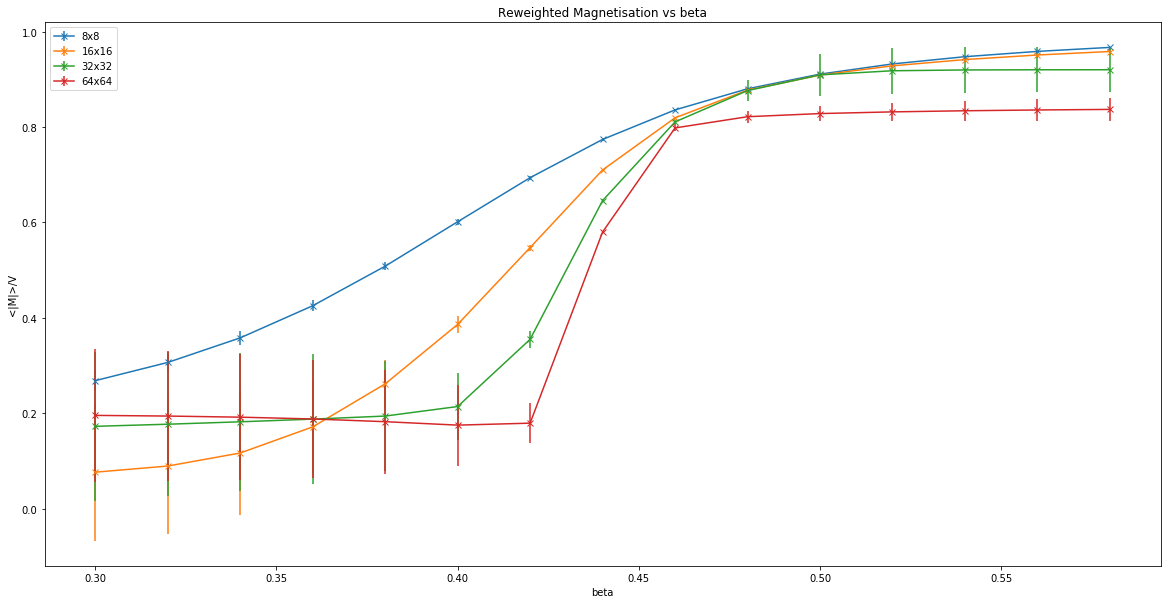

In [4]:
plt.figure()
for L in Lvals:
    plt.errorbar(reweighted_M[L][:,0], reweighted_M[L][:,1]/(L*L), yerr=reweighted_M[L][:,2]/(L*L), marker="x", label="%dx%d"%(L,L))
plt.ylabel('<|M|>/V')
plt.xlabel('beta')
plt.legend()
plt.title('Reweighted Magnetisation vs beta')
plt.show()

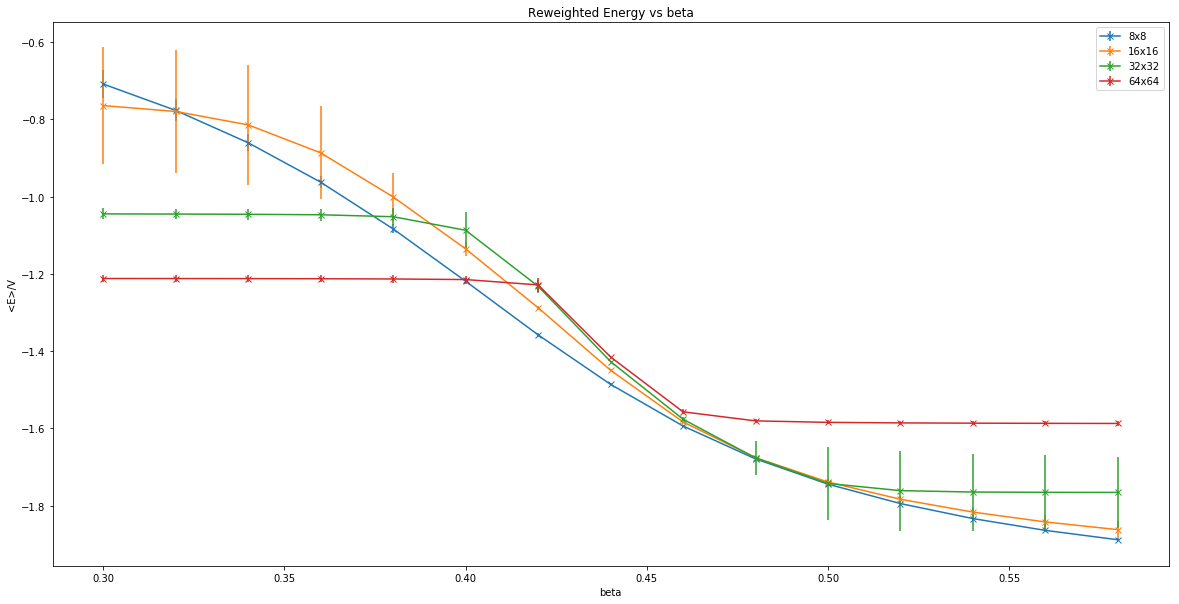

In [5]:
plt.figure()
for L in Lvals:
    plt.errorbar(reweighted_E[L][:,0], reweighted_E[L][:,1]/(L*L), yerr=reweighted_E[L][:,2]/(L*L), marker="x", label="%dx%d"%(L,L))
plt.ylabel('<E>/V')
plt.xlabel('beta')
plt.legend()
plt.title('Reweighted Energy vs beta')
plt.show()

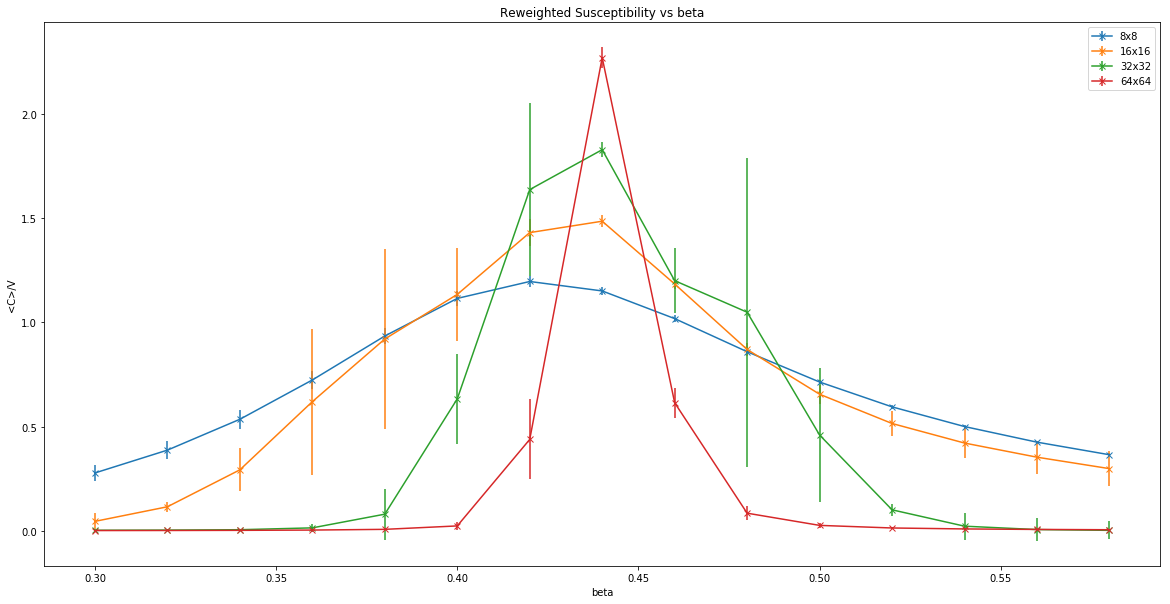

In [6]:
plt.figure()
for L in Lvals:
    plt.errorbar(reweighted_C[L][:,0], reweighted_C[L][:,1]/(L*L), yerr=reweighted_C[L][:,2]/(L*L), marker="x", label="%dx%d"%(L,L))
plt.ylabel('<C>/V')
plt.xlabel('beta')
plt.legend()
plt.title('Reweighted Susceptibility vs beta')
plt.show()

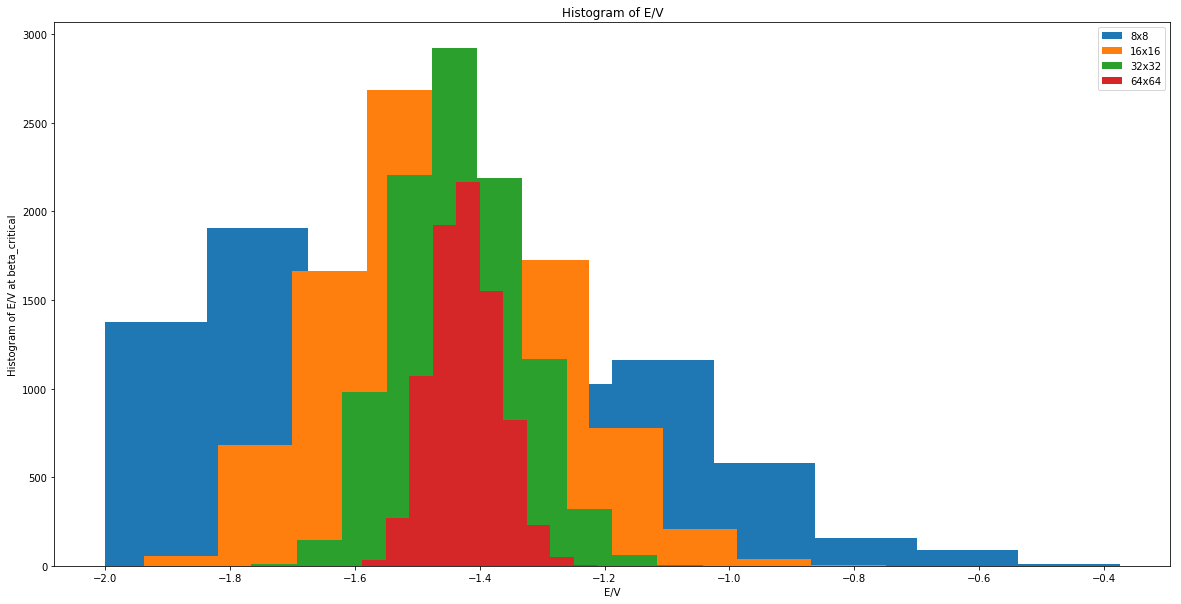

In [7]:
plt.figure()
for L in Lvals:
    plt.hist(dat[L][:,0]/(L*L), label="%dx%d"%(L,L))
plt.ylabel('Histogram of E/V at beta_critical')
plt.xlabel('E/V')
plt.legend()
plt.title('Histogram of E/V')
plt.show()